In [1]:
#!/usr/bin/env python
# coding: utf-8
import os
""" Setting """
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
wandb_prefix_name = "warp_mask_SINGLE"
know_args = ['--note',"mix no warp",
             "--no_warp_ratio", "0.0625",
             "--log_dir",f"/workspace/inpaint_mask/log/{wandb_prefix_name}/",
             "--data_dir","/workspace/inpaint_mask/data/warpData/celeba/",
            #  "--data_dir","/workspace/inpaint_mask/data/warpData/fashionLandmarkDetectionBenchmark/",
             # "--data_dir", "/workspace/inpaint_mask/data/warpData/CIHP/Training/",
             # "--data_dir", "/workspace/inpaint_mask/data/warpData/Celeb-reID-light/train/",
             '--mask_type', "tri",
             '--varmap_type', "small_grid",
             '--varmap_threshold',"-1",
            #  "--backbone","vqvae",
             "--mask_weight","1",
             
             "--batch_size","16",

             '--guassian_ksize','17',
             '--guassian_sigma','0.0',
             '--guassian_blur',
            #  '--use_attention',
            #  '--mask_inverse',
            #  "--in_out_area_split",
             "--wandb"
            ]
# image_size = (256,128)
image_size = (256,256)
# image_size = (512,512)
seed = 5
test_size = 0.1
val_batch_num = 6
device = "cuda"
weight_cliping_limit = 0.01

# assert args.D_iter > args.G_iter,print("WGAN Need D_iter > G_iter") # wgan parameters

from losses.bl1_loss import BalancedL1Loss
from metric import BinaryMetrics 
from losses.poly_loss import PolyBCELoss 
import torch
import numpy as np
from tqdm.auto import tqdm
from get_args import get_args
from utils import (
    seed_everything,
    checkallData,
    check_create_dir,
    create_guassian_blur_f,
    to_pillow_f,
)
from loss_utils import (
    calculate_mask_loss_with_split,
    calc_gradient_penalty
)
from warp_dataset import WarppedDataset
from sklearn.model_selection import train_test_split
import timm
from models.generators.mask_estimator import MaskEstimator
from natsort import natsorted
import matplotlib.pyplot as plt

seed_everything(seed)
args = get_args(know_args)
if (args.backbone != "vqvae"):
    assert len(timm.list_models(args.backbone,pretrained=True)) !=0, print(f"no such backbone {args.backbone} ")
args.image_size = image_size
print(vars(args))


mask_img_f = lambda mask,img: img*(mask) 
if args.mask_inverse:
    mask_img_f = lambda mask,img: img*(1. - mask) + mask
else:
    mask_img_f = lambda mask,img: img*(mask) 

{'note': 'mix no warp', 'no_warp_ratio': 0.0625, 'mask_inverse': False, 'mask_type': 'tri', 'varmap_type': 'small_grid', 'varmap_threshold': -1.0, 'guassian_blur': True, 'guassian_ksize': 17, 'guassian_sigma': 0.0, 'epoch': 200, 'batch_size': 16, 'lr': 0.0002, 'backbone': 'convnext_base_in22k', 'use_attention': False, 'D_iter': 5, 'G_iter': 1, 'type': 'wgangp', 'gp_lambda': 10, 'mask_weight': 1.0, 'matt_weight': 100.0, 'regularzation_weight': 0.05, 'in_out_area_split': False, 'in_area_weight': 0.5, 'out_area_weight': 0.5, 'data_dir': '/workspace/inpaint_mask/data/warpData/celeba/', 'log_dir': '/workspace/inpaint_mask/log/warp_mask_SINGLE/', 'wandb': True, 'image_size': (256, 256)}


In [ ]:
""" Train Val Split """
d_dir = f"{args.data_dir}/{args.mask_type}/"
origin_dir = f"{d_dir}/origin/"
image_names = natsorted(os.listdir(origin_dir))
image_id_list = list(map(lambda s: s.split('.')[0], image_names))
print(len(image_id_list))

# checkallData(d_dir,image_id_list)
print("Seed:",seed)
train_ids, valid_ids = train_test_split(image_id_list , test_size=test_size, random_state=seed)
print("Total train data:",len(train_ids))
print("Total valid data:", len(valid_ids))
print(valid_ids[:5])

In [13]:
image_size = (512,512)
filename= "03.jpeg"
test_dir = "/workspace/inpaint_mask/data/test/"
warpped_dir = f"{test_dir}/warpped/"
origin_dir = f"{test_dir}/origin/"
ckpt_path = '/workspace/inpaint_mask/log/warp_mask_SINGLE/ojhgdob4/ckpts/ckpt_1001_0.pt'
# ckpt_path = '/workspace/inpaint_mask/log/warp_mask_SINGLE/2e9ztqt2/ckpts/ckpt_1001_0.pt'
# ckpt_path = '/workspace/inpaint_mask/log/warp_mask_SINGLE/2e9ztqt2/ckpts/ckpt_3001_0.pt'
# ckpt_path = '/workspace/inpaint_mask/log/warp_mask_SINGLE/2e9ztqt2/ckpts/ckpt_12001_1.pt'

# ckpt_path = '/workspace/inpaint_mask/log/warp_mask_SINGLE/2e9ztqt2/ckpts/ckpt_36001_5.pt'

# ckpt_path = '/workspace/inpaint_mask/log/3l8xx8qk/ckpt_7001_0.pt'
device = 'cpu'

In [67]:
# image_size = (256,256)
# # '050734', '088880', '137281', '119290', '028944'
# filename= "flickr_0503.png"
# test_dir = "/workspace/inpaint_mask/data/fal/"
# # test_dir = "/workspace/inpaint_mask/data/warpData/celeba/tri/"
# # warpped_dir = f"{test_dir}/warpped/"
# warpped_dir = f"{test_dir}/modified/"
# # origin_dir = f"{test_dir}/origin/"
# origin_dir = f"{test_dir}/reference/"

# # ckpt_path = '/workspace/inpaint_mask/log/3l8xx8qk/ckpt_7001_0.pt'
# ckpt_path = '/workspace/inpaint_mask/log/warp_mask_SINGLE/50fz2jcl/ckpts/ckpt_22001_1.pt'
# device = 'cpu'

In [3]:
G = MaskEstimator(image_size = image_size, backbone = args.backbone, use_attention= args.use_attention)
G = G.to(device)
# G.load_state_dict(torch.load(ckpt_path)['MG_state_dict'])
G.load_state_dict(torch.load(ckpt_path)['G_state_dict'])

convnext_base_in22k
md_channels [1024, 512, 256, 128, 64, 1]
[(2048, 512), (1024, 256), (512, 128), (256, 64)]


<All keys matched successfully>

In [4]:
import torchvision.transforms as  transforms
import torchvision
from PIL import Image

In [5]:
centor_crop_f = torchvision.transforms.CenterCrop(size=image_size)
to_pillow_f = torchvision.transforms.ToPILImage()

basic_transform = transforms.Compose(
    [
            transforms.ToTensor(),
            transforms.Normalize((0., 0., 0.), (1., 1., 1.))
    ])

In [15]:

# img_pillow_origin = Image.open(f"{origin_dir}/{filename}").convert('RGB')
warpped_pillow = Image.open(f"{warpped_dir}/{filename}").convert('RGB')
img_pillow_origin = warpped_pillow
# warpped_pillow = img_pillow_origin


""" preprocess v1""" 
origin_size = max(warpped_pillow.size[0],warpped_pillow.size[1])
scale_factor = min(image_size[0],image_size[1]) / origin_size
img_pillow_warpped = torchvision.transforms.functional.affine(warpped_pillow, scale = scale_factor, angle = 0.0, translate=(0,0),shear=0.0)            
warpped_centor_cropped = centor_crop_f(img_pillow_warpped)

img_pillow = torchvision.transforms.functional.affine(img_pillow_origin, scale = scale_factor, angle = 0.0, translate=(0,0),shear=0.0)            
image_centor_cropped = centor_crop_f(img_pillow)

# """ preprocess v2 """ 
# warpped_centor_cropped = centor_crop_f(warpped_pillow)


test_image_tensor torch.Size([1, 3, 512, 512])


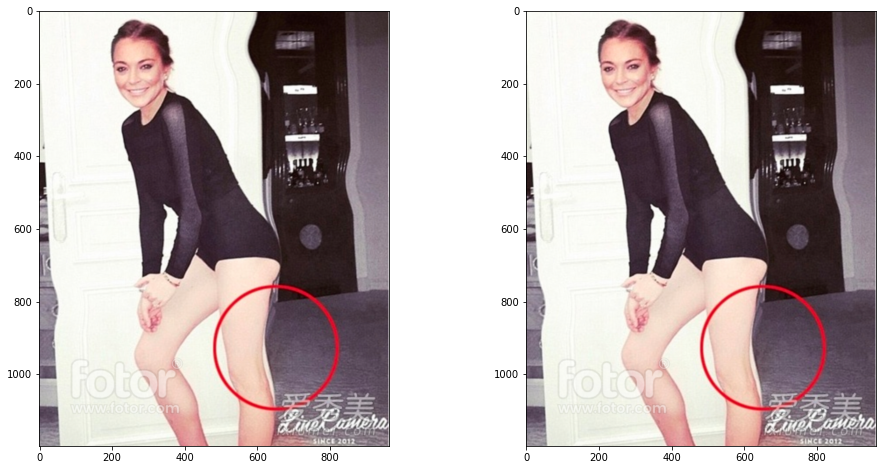

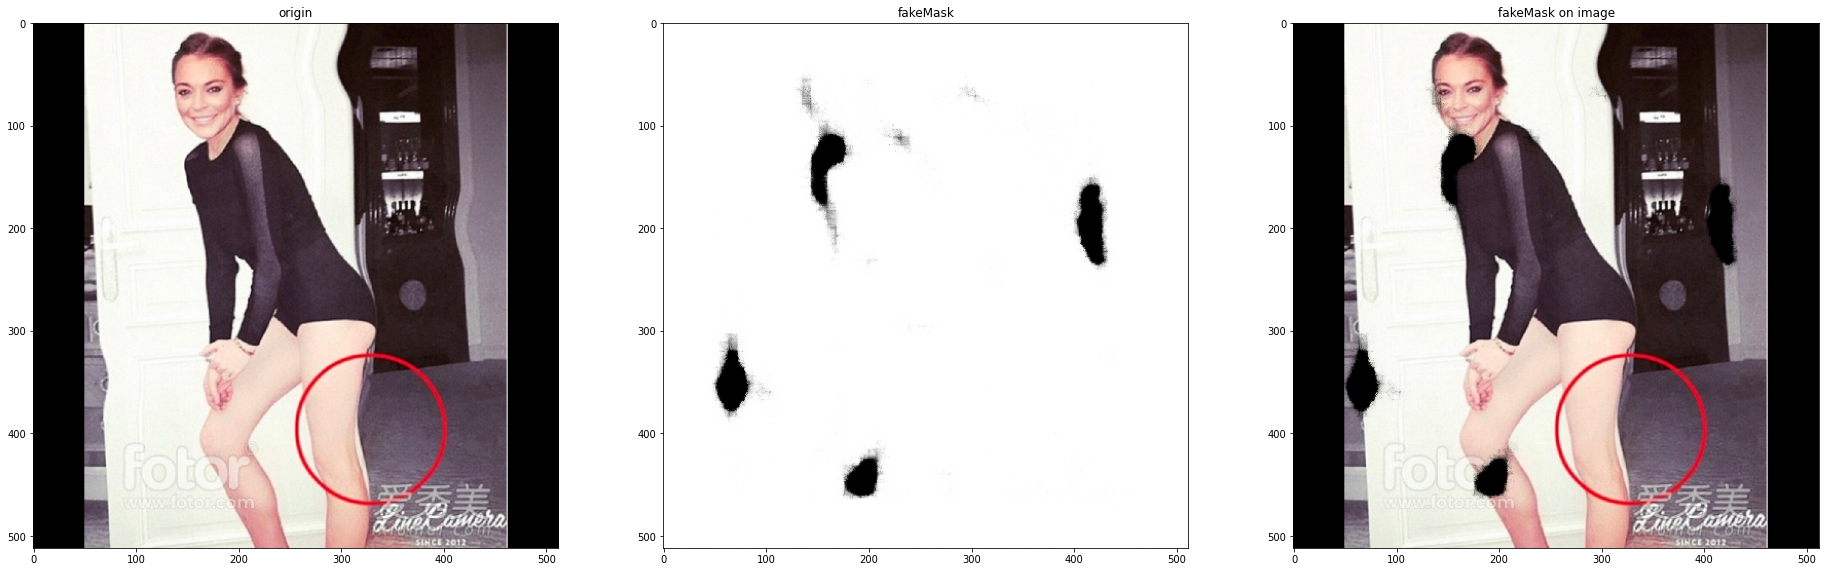

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(16,8))
axs[0].imshow(img_pillow_origin)
axs[1].imshow(warpped_pillow )

test_image_tensor = basic_transform(warpped_centor_cropped) 
test_image_tensor = test_image_tensor.unsqueeze(0)
print("test_image_tensor",test_image_tensor.shape)
# fake_images, fake_masks = G(test_image_tensor)

fake_masks = G(test_image_tensor)
# plot result
fig, axs = plt.subplots(1, 3, figsize=(32,16))
axs[0].set_title('origin')
axs[0].imshow( to_pillow_f(test_image_tensor[0]) )

# axs[1].set_title('fakeImage')
# axs[1].imshow( to_pillow_f(fake_images[0]) ) 

axs[1].set_title('fakeMask')
axs[1].imshow( to_pillow_f(fake_masks[0]),vmin=0, vmax=255,cmap='gray' )

axs[2].set_title('fakeMask on image')
axs[2].imshow( to_pillow_f(fake_masks[0]*test_image_tensor[0]))

fig.show()

In [195]:
# """ Train Val Split """
# d_dir = f"{args.data_dir}/{args.mask_type}/"
# origin_dir = f"{d_dir}/origin/"
# image_names = natsorted(os.listdir(origin_dir))
# image_id_list = list(map(lambda s: s.split('.')[0], image_names))
# print(len(image_id_list))

# # checkallData(d_dir,image_id_list)
# print("Seed:",seed)
# train_ids, valid_ids = train_test_split(image_id_list , test_size=test_size, random_state=seed)
# print("Total train data:",len(train_ids))
# print("Total valid data:", len(valid_ids))

